# Using CNN on lung xraus to detect infected lungs


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os 
import cv2
import pickle
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
np.random.seed(22)

In [3]:
def load_normal(norm_path):
    norm_files = np.array(os.listdir(norm_path))
    norm_labels = np.array(['normal']*len(norm_files))
    
    norm_images = []
    for image in tqdm(norm_files):
        image = cv2.imread(norm_path + image)
        image = cv2.resize(image, dsize=(200,200))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        norm_images.append(image)
        
    norm_images = np.array(norm_images)
    
    return norm_images, norm_labels

In [4]:
def load_pneumonia(pneu_path):
    pneu_files = np.array(os.listdir(pneu_path))
    pneu_labels = np.array([pneu_file.split('_')[1] for pneu_file in pneu_files])
    
    pneu_images = []
    for image in tqdm(pneu_files):
        image = cv2.imread(pneu_path + image)
        image = cv2.resize(image, dsize=(200,200))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        pneu_images.append(image)
        
    pneu_images = np.array(pneu_images)
    
    return pneu_images, pneu_labels

In [5]:
norm_images, norm_labels = load_normal('/content/drive/MyDrive/chest_xray/train/NORMAL/')

100%|██████████| 1341/1341 [02:01<00:00, 11.05it/s]


In [6]:
pneu_images, pneu_labels = load_pneumonia('/content/drive/MyDrive/chest_xray/train/PNEUMONIA/')

100%|██████████| 3875/3875 [02:27<00:00, 26.29it/s]


In [7]:
X_train = np.append(norm_images, pneu_images, axis=0)
y_train = np.append(norm_labels, pneu_labels)

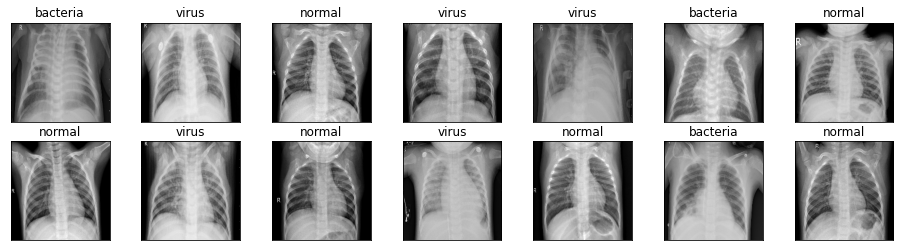

In [8]:
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(16, 4))

indices = np.random.choice(len(X_train), 14)
counter = 0

for i in range(2):
    for j in range(7):
        axes[i,j].set_title(y_train[indices[counter]])
        axes[i,j].imshow(X_train[indices[counter]], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        counter += 1
plt.show()

In [9]:
norm_images_test, norm_labels_test = load_normal('/content/drive/MyDrive/chest_xray/test/NORMAL/')
pneu_images_test, pneu_labels_test = load_pneumonia('/content/drive/MyDrive/chest_xray/test/PNEUMONIA/')
X_test = np.append(norm_images_test, pneu_images_test, axis=0)
y_test = np.append(norm_labels_test, pneu_labels_test)

100%|██████████| 390/390 [00:10<00:00, 38.54it/s]


In [10]:
# Use this to save variables
with open('pneumonia_data.pickle', 'wb') as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)# Use this to load variables
with open('pneumonia_data.pickle', 'rb') as f:
    (X_train, X_test, y_train, y_test) = pickle.load(f)

In [11]:
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]
one_hot_encoder = OneHotEncoder(sparse=False)
y_train_one_hot = one_hot_encoder.fit_transform(y_train)
y_test_one_hot = one_hot_encoder.transform(y_test)

In [12]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [13]:
datagen = ImageDataGenerator(
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train_one_hot, batch_size=32)

In [14]:
input1 = Input(shape=(X_train.shape[1], X_train.shape[2], 1))

cnn = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), 
    padding='same')(input1)
cnn = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)

cnn = Conv2D(16, (2, 2), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = Conv2D(32, (2, 2), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)

cnn = Flatten()(cnn)
cnn = Dense(100, activation='relu')(cnn)
cnn = Dense(50, activation='relu')(cnn)
output1 = Dense(3, activation='softmax')(cnn)

model = Model(inputs=input1, outputs=output1)

In [21]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['acc'])

history = model.fit_generator(train_gen, epochs=3, 
          validation_data=(X_test, y_test_one_hot))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/3
163/163 [==============================] - 400s 2s/step - loss: 0.7627 - acc: 0.6764 - val_loss: 1.0067 - val_acc: 0.6603
Epoch 2/3
163/163 [==============================] - 395s 2s/step - loss: 0.6627 - acc: 0.7197 - val_loss: 0.8833 - val_acc: 0.6875
Epoch 3/3
163/163 [==============================] - 390s 2s/step - loss: 0.6229 - acc: 0.7320 - val_loss: 1.0271 - val_acc: 0.6683


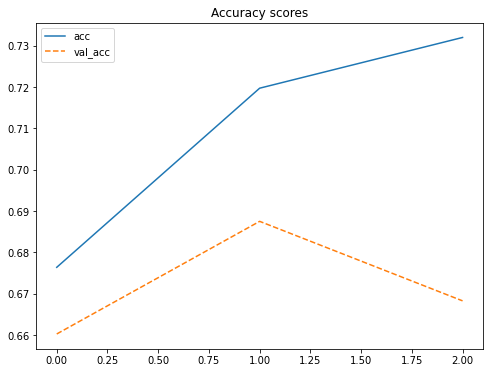

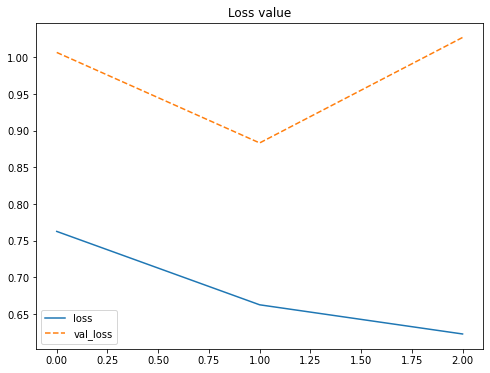

In [22]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'], linestyle = 'dashed')
plt.legend(['acc', 'val_acc'])
plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], linestyle = 'dashed')
plt.legend(['loss', 'val_loss'])
plt.show()

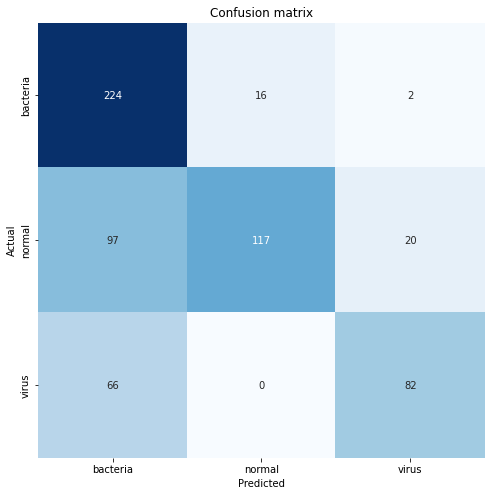

In [18]:
predictions = model.predict(X_test)
predictions = one_hot_encoder.inverse_transform(predictions)
cm = confusion_matrix(y_test, predictions)

classnames = ['bacteria', 'normal', 'virus']
plt.figure(figsize=(8,8))
plt.title('Confusion matrix')
sns.heatmap(cm, cbar=False, xticklabels=classnames, yticklabels=classnames, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()